# Summary

Generate training and validation datasets.

----

# Imports

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [24]:
%run _imports.ipynb

Setting the PACKAGE_NAME environment variable.
Setting the PACKAGE_VERSION environment variable.
Setting the DOCS_SECRET_KEY environment variable.
Setting the PYTHON_VERSION environment variable.
Setting the SPARK_MASTER environment variable.
Setting the SPARK_ARGS environment variable.
Setting the DB_TYPE environment variable.
Setting the DB_PORT environment variable.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2018-02-06 11:53:59.239360


In [25]:
%run _settings.ipynb

/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet


In [26]:
%run _spark.ipynb

In [27]:
import random
from typing import NamedTuple

import h5py
from sklearn import metrics

In [28]:
import pagnn
importlib.reload(pagnn)

<module 'pagnn' from '/home/kimlab1/strokach/working/pagnn/pagnn/__init__.py'>

# Parameters

In [29]:
NOTEBOOK_NAME = 'mutation_datasets'
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).absolute()
NOTEBOOK_PATH.mkdir(exist_ok=True)

In [30]:
os.environ['DATABIN_DIR']

'/home/kimlab2/database_data/databin'

# Datasets

## Gene3D domains

In [31]:
with open(f'generate_datasets/gene3d_domains.pickle', 'rb') as fin:
    GENE3D_DOMAINS = pickle.load(fin)

FileNotFoundError: [Errno 2] No such file or directory: 'generate_datasets/gene3d_domains.pickle'

## Training / validation domains

In [32]:
with open(f'generate_datasets/training_domains.pickle', 'rb') as fin:
    TRAINING_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/validation_domains.pickle', 'rb') as fin:
    VALIDATION_DOMAINS = pickle.load(fin)
    
with open(f'generate_datasets/test_domains.pickle', 'rb') as fin:
    TEST_DOMAINS = pickle.load(fin)

FileNotFoundError: [Errno 2] No such file or directory: 'generate_datasets/training_domains.pickle'

## Training / validation parquet files

In [33]:
with open(f'generate_datasets/training_parquet_files.pickle', 'rb') as fin:
    TRAINING_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/validation_parquet_files.pickle', 'rb') as fin:
    VALIDATION_PARQUET_FILES = pickle.load(fin)
    
with open(f'generate_datasets/test_parquet_files.pickle', 'rb') as fin:
    TEST_PARQUET_FILES = pickle.load(fin)

FileNotFoundError: [Errno 2] No such file or directory: 'generate_datasets/training_parquet_files.pickle'

## Output folders

In [34]:
VALIDATION_DIR = NOTEBOOK_PATH.joinpath('validation')
VALIDATION_DIR.mkdir(exist_ok=True)
VALIDATION_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/validation')

In [35]:
PROTHERM_DIR = NOTEBOOK_PATH.joinpath('protherm')
PROTHERM_DIR.mkdir(exist_ok=True)
PROTHERM_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm')

In [36]:
HUMSAVAR_DIR = NOTEBOOK_PATH.joinpath('humsavar')
HUMSAVAR_DIR.mkdir(exist_ok=True)
HUMSAVAR_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/humsavar')

# Datasets

## External validation dataset

### Uniparc xref

In [37]:
uniparc_xref_file = op.join(os.environ['DATABIN_DIR'], 'uniparc', 'v0.1.0', 'uniparc_xref.parquet')
uniparc_xref_file

'/home/kimlab2/database_data/databin/uniparc/v0.1.0/uniparc_xref.parquet'

In [38]:
!ls {uniparc_xref_file} -lSh

-rw-rw-rw- 1 strokach kimlab 16G Nov 15 12:48 /home/kimlab2/database_data/databin/uniparc/v0.1.0/uniparc_xref.parquet


In [39]:
ds = spark.sql(f"""\
SELECT *
FROM parquet.`{uniparc_xref_file}`
""")

In [40]:
ds.limit(10).toPandas()

,uniparc_id,idx,db_type,db_id,version_i,active,version,created,last,__index_level_0__
0,UPI0000000011,1,PRF,3119392DP,1,Y,NaN,2006-02-13,2009-09-01,0
1,UPI0000000011,2,PRF,3119392TK,1,Y,NaN,2006-02-13,2009-09-01,1
2,UPI0000000011,3,PRF,3121328BV,1,Y,NaN,2006-02-13,2009-09-01,2
3,UPI0000000011,4,PRF,3216358CT,1,Y,NaN,2007-01-01,2009-09-01,3
4,UPI0000000011,5,PRF,3216358FBB,1,Y,NaN,2007-01-01,2009-09-01,4
5,UPI0000000011,6,PRF,3315290CD,1,Y,NaN,2007-12-07,2009-09-01,5
6,UPI0000000011,7,EMBL,AAA48061,1,Y,1.0,2003-03-12,2017-05-26,6
7,UPI0000000011,8,EMBL,AAB96437,1,Y,1.0,2003-03-12,2017-05-26,7
8,UPI0000000011,9,EMBL,AAQ93171,1,Y,1.0,2006-05-04,2017-05-26,8
9,UPI0000000011,10,EMBL,AAR17917,1,Y,1.0,2006-05-04,2017-05-26,9


In [41]:
# 'UniProtKB/Swiss-Prot' | 'UniProtKB/TrEMBL'
# active = 'Y'
# db_id = ''

### Adjacency matrix

In [42]:
ADJACENCY_MATRIX_PATH

PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet')

In [43]:
ds = spark.sql(f"""\
SELECT *
FROM parquet.`{ADJACENCY_MATRIX_PATH}`
""")

In [44]:
ds.limit(10).toPandas()

,uniparc_id,sequence,database,interpro_name,interpro_id,domain_start,domain_end,__index_level_0__,domain_length,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,evalue_log10,bitscore,qseq,sseq,a2b,b2a,residue_idx_1,residue_idx_2,residue_id_1,residue_id_2,residue_aa_1,residue_aa_2,residue_idx_1_corrected,residue_idx_2_corrected,database_id
0,UPI000AF78023,AAAALLPLAASAAPARGTLLKSSVLSSYTSQAIGTLLANAQSTDQAKCDVRLAEFTYATIGVNGEPATASGTLLVPGGSQCAGPFPLVSYSQGTESLRHAEQAKEIRDAKGDDTIV...,Gene3D,Alpha/Beta hydrolase fold,IPR029058,11,287,700874249,277,3H2G,0.0,A,74.24,264.0,65.0,1.0,14.0,277.0,1.0,261.0,-143.000000,414.0,PARGTLLKSSVLSSYTSQAIGTLLANAQSTDQAKCDVRLAEFTYATIGVNGEPATASGTLLVPGGSQCAGPFPLVSYSQGTESLRHAEQAKEIRDAKGDDTIVTHLATQGYVVVSS...,PARGTLLTSNFLTSYTRDAISAMLA---SPEQAKCNVRVAEFTYATIGVEGEPATASGVLLIPGGERCSGPYPLLGWGHPTEALRAQEQAKEIRDAKGDDPLVTRLASQGYVVVGS...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, ...","[1.0, 2.0, 4.0, 6.0, 41.0, 0.0, 2.0, 3.0, 4.0, 41.0, 0.0, 1.0, 3.0, 4.0, 41.0, 42.0, 43.0, 135.0, 138.0, 139.0, 142....","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, ...","[3.0, 4.0, 6.0, 8.0, 52.0, 2.0, 4.0, 5.0, 6.0, 52.0, 2.0, 3.0, 5.0, 6.0, 52.0, 53.0, 54.0, 146.0, 149.0, 150.0, 153....","[P, P, P, P, P, A, A, A, A, A, R, R, R, R, R, R, R, R, R, R, R, G, G, G, G, G, G, G, G, G, G, G, T, T, T, T, T, T, T...","[A, R, T, L, A, P, R, G, T, A, P, A, G, T, A, T, I, S, I, D, R, A, R, T, L, Y, A, T, D, R, A, S, P, A, R, G, L, L, T...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, ...","[1.0, 2.0, 4.0, 6.0, 44.0, 0.0, 2.0, 3.0, 4.0, 44.0, 0.0, 1.0, 3.0, 4.0, 44.0, 45.0, 46.0, 138.0, 141.0, 142.0, 145....",G3DSA:3.40.50.1820
1,UPI0009F3B2EE,AAAAPRPPPAGRRPGRVSARTHHYGPHRHGPHPDQFLELTLPSGDGPAPVAVVLHGGFWRAAYGIELARPLAADLAAAGWAAVAVEYRRGGTGGWSAPLEDVAAALDALPGLAERD...,Gene3D,Alpha/Beta hydrolase fold,IPR029058,83,355,756058084,273,5AOA,0.0,A,27.86,201.0,134.0,4.0,52.0,249.0,43.0,235.0,-6.096910,50.4,VVLHGGFWRAAYGIELARPLAADLAAAGWAAVAVEYRRGGTGGWSA--PLEDVAAALDALPGLAERDRLDLADLTVVGHSAGGHLAAWAAGRGRLPDGAPGAGPRVRVTAAVLQAG...,VFFFGGGWQSGSPAQF-RPQCEYFAGRGMVAMAADYRVGSRHNVKVADCVADAKSAIRWVRQHAAELGVDPQKIVASGGSAGGHLAACTVMVPDLEAPEEDHTISSQANAAILFNP...,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 18.0, 19.0, 20.0, 21.0, 22.0...","[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, None, 17.0, 18.0, 19.0, 20.0...","[42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 42.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 43.0, 4...","[43.0, 44.0, 72.0, 74.0, 96.0, 97.0, 100.0, 114.0, 115.0, 116.0, 117.0, 42.0, 44.0, 45.0, 57.0, 60.0, 61.0, 64.0, 71...","[48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 4...","[49.0, 50.0, 78.0, 80.0, 102.0, 103.0, 106.0, 120.0, 121.0, 122.0, 123.0, 48.0, 50.0, 51.0, 63.0, 66.0, 67.0, 70.0, ...","[V, V, V, V, V, V, V, V, V, V, V, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F, F...","[F, F, M, A, A, I, V, I, V, A, S, V, F, F, F, Q, C, F, A, M, A, A, S, G, F, V, F, F, G, F, A, Y, A, A, I, A, S, G, G...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 2.0, 31.0, 33.0, 53.0, 54.0, 57.0, 71.0, 72.0, 73.0, 74.0, 0.0, 2.0, 3.0, 15.0, 19.0, 20.0, 23.0, 30.0, 31.0, ...",G3DSA:3.40.50.1820
2,UPI0005F71968,AAAAVHLVVLQHGLWGTPQNLGALQERLEAALQALAGPERIVMENSAVNERRRTHDGIDTCGDRLAQLILARTAQLRLDGHRVA

### Protherm dataset

In [45]:
protherm_file = (
    op.join(os.environ['DATABIN_DIR'], 'protein_folding_energy', 'v0.1.0', 'protherm_star.parquet')
)

#### Examine file

In [46]:
protherm = pq.read_table(protherm_file).to_pandas().set_index('__index_level_0__')

In [47]:
display(protherm.head())
print(protherm.shape)

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,ddg_exp_std,ddg_exp_count
__index_level_0__,,,,,,,,,
0,1a2p,A,A_A32C,P00648,A79C,PF00545,1.838100,NaN,1
1,1a2p,A,A_A32D,P00648,A79D,PF00545,0.414300,NaN,1
2,1a2p,A,A_A32E,P00648,A79E,PF00545,-0.132800,NaN,1
3,1a2p,A,A_A32F,P00648,A79F,PF00545,0.436800,NaN,1
4,1a2p,A,A_A32G,P00648,A79G,PF00545,0.860767,0.067954,3


(2997, 9)


In [48]:
protherm = protherm.dropna(subset=['uniprot_id', 'uniprot_mutation', 'ddg_exp'])

In [49]:
protherm.shape

(2997, 9)

#### Spark query

In [50]:
ADJACENCY_MATRIX_PATH

PosixPath('/home/kimlab2/database_data/databin/uniparc_domain/0.1/adjacency_matrix.parquet')

In [51]:
ds = spark.sql(f"""\
SELECT
    ds.uniprot_id, ds.uniprot_mutation, ds.ddg_exp,
    
    xref.uniparc_id,
    
    ud.sequence, ud.database_id, ud.domain_start, ud.domain_end, ud.__index_level_0__ domain_index,
       
    ud.structure_id, ud.model_id, ud.chain_id,
    ud.pc_identity, ud.alignment_length, ud.mismatches, ud.gap_opens, 
    ud.q_start, ud.q_end, ud.s_start, ud.s_end,
    
    ud.qseq, ud.sseq,
    ud.residue_idx_1_corrected, ud.residue_idx_2_corrected

FROM parquet.`{protherm_file}` ds
JOIN parquet.`{uniparc_xref_file}` xref ON (uniprot_id = db_id)
JOIN parquet.`{ADJACENCY_MATRIX_PATH}` ud USING (uniparc_id)
WHERE (xref.db_type = 'UniProtKB/Swiss-Prot' OR xref.db_type = 'UniProtKB/TrEMBL')
AND xref.active = 'Y'
""")

In [52]:
ds.write.parquet(
    PROTHERM_DIR.joinpath('protherm_2.parquet').as_posix(),
    mode='overwrite',
)

#### Remove mutations outside domains

In [53]:
protherm_df = pq.ParquetDataset(PROTHERM_DIR.joinpath('protherm_2.parquet').as_posix()).read().to_pandas()

[autoreload of pagnn failed: Traceback (most recent call last):
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/kimlab1/strokach/anaconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/kimlab1/strokach/working/pagnn/pagnn/__init__.py", line 8, in <module>
    from . import *
AttributeError: module 'pagnn' has no at

Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm/protherm_2.parquet/.part-00174-d5970bbe-d13b-4285-bc18-a4cc440e23e8-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm/protherm_2.parquet/.part-00126-d5970bbe-d13b-4285-bc18-a4cc440e23e8-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm/protherm_2.parquet/.part-00189-d5970bbe-d13b-4285-bc18-a4cc440e23e8-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm/protherm_2.parquet/.part-00026-d5970bbe-d13b-4285-bc18-a4cc440e23e8-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm/protherm_2.parquet/.part-00036-d

In [54]:
display(protherm_df.head(2))
print(protherm_df.shape[0])

,uniprot_id,uniprot_mutation,ddg_exp,uniparc_id,sequence,database_id,domain_start,domain_end,domain_index,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,qseq,sseq,residue_idx_1_corrected,residue_idx_2_corrected
0,P08921,V100A,3.01,UPI0000127348,RDSGTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPFLKSGAFEILANGDLKIKNLTRDDSGTYNVTVYSTNGTRILDKALDLRILE,G3DSA:2.60.40.10,23,121,378750125,1HNG,0.0,A,98.98,98.0,1.0,0.0,2.0,99.0,1.0,98.0,DSGTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPFLKSGAFEILANGDLKIKNLTRDDSGTYNVTVYSTNGTRILDKALDLRILE,DSGTVWGALGHGINLNIPNFQMTDDIDEVRWERGSTLVAEFKRKMKPFLKSGAFEILANGDLKIKNLTRDDSGTYNVTVYSTNGTRILNKALDLRILE,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 88.0, 89.0, 90.0, 0.0, 2.0, 3.0, 90.0, 91.0, 0.0, 1.0, 3.0, 4.0, 90.0, 91.0, 92.0, 1.0, 2.0, 4.0, 5.0, 92..."
1,P08921,V100A,3.01,UPI0000127348,MVSKPMIYWECSNATLTCEVLEGTDVELKLYQGKEHLRSLRQKTMSYQWTNLRAPFKCKAVNRVSQESEMEVVNCPE,G3DSA:2.60.40.10,122,198,378750126,1CCZ,0.0,A,100.00,77.0,0.0,0.0,1.0,77.0,95.0,171.0,MVSKPMIYWECSNATLTCEVLEGTDVELKLYQGKEHLRSLRQKTMSYQWTNLRAPFKCKAVNRVSQESEMEVVNCPE,MVSKPMIYWECSNATLTCEVLEGTDVELKLYQGKEHLRSLRQKTMSYQWTNLRAPFKCKAVNRVSQESEMEVVNCPE,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, ...","[1.0, 2.0, 21.0, 22.0, 61.0, 63.0, 64.0, 0.0, 2.0, 3.0, 19.0, 21.0, 22.0, 25.0, 59.0, 60.0, 61.0, 64.0, 65.0, 66.0, ..."


416


In [55]:
importlib.reload(pagnn.utils)

<module 'pagnn.utils' from '/home/kimlab1/strokach/working/pagnn/pagnn/utils/__init__.py'>

In [56]:
protherm_df = pagnn.filter_mismatch_mutations(protherm_df)

Removing 10 rows containing mutations that are outside domains.
Removing 0 rows containing mutations do not match sequence.
Removing 0 rows containing mutations that are outside alignment with structure.


In [57]:
protherm_df.shape[0]

406

(array([   1.,   21.,  187.,  114.,   60.,   17.,    4.,    0.,    1.,    1.]),
 array([ -4.   ,  -2.377,  -0.754,   0.869,   2.492,   4.115,   5.738,
          7.361,   8.984,  10.607,  12.23 ]),
 <a list of 10 Patch objects>)

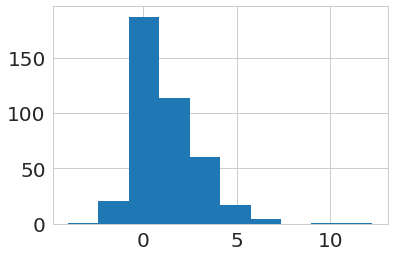

In [58]:
plt.hist(protherm_df['ddg_exp'])

In [59]:
pq.write_table(
    pa.Table.from_pandas(protherm_df, preserve_index=False),
    NOTEBOOK_PATH.joinpath('protherm_validaton_dataset.parquet').as_posix(),
    version='2.0',
    flavor='spark',
)

In [60]:
PROTHERM_DIR

PosixPath('/home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/protherm')

### Humsavar dataset

In [61]:
humsavar_file = (
    op.join(os.environ['DATABIN_DIR'], 'mutation_sets', 'v0.1.0', 'humsavar.parquet')
)

#### Examine file

In [62]:
humsavar = pq.read_table(humsavar_file).to_pandas().set_index('__index_level_0__')

In [63]:
display(humsavar.head())
print(humsavar.shape)

,hgnc_id,uniprot_id,swissvar_id,aa_change,type_of_variant,dbsnp_id,disease,uniprot_mutation
__index_level_0__,,,,,,,,
0,A1BG,P04217,VAR_018369,p.His52Arg,Polymorphism,rs893184,None,H52R
1,A1BG,P04217,VAR_018370,p.His395Arg,Polymorphism,rs2241788,None,H395R
2,A1CF,Q9NQ94,VAR_052201,p.Val555Met,Polymorphism,rs9073,None,V555M
3,A1CF,Q9NQ94,VAR_059821,p.Ala558Ser,Polymorphism,rs11817448,None,A558S
4,A2ML1,A8K2U0,VAR_055463,p.Gly207Arg,Polymorphism,rs11047499,None,G207R


(77598, 8)


In [64]:
humsavar = humsavar.dropna(subset=['uniprot_id', 'uniprot_mutation', 'type_of_variant'])

In [65]:
humsavar.shape

(77598, 8)

#### Spark query

In [66]:
ds = spark.sql(f"""\
SELECT
    ds.uniprot_id, ds.uniprot_mutation, ds.type_of_variant,
    
    xref.uniparc_id,
    
    ud.sequence, ud.database_id, ud.domain_start, ud.domain_end, ud.__index_level_0__ domain_index,
       
    ud.structure_id, ud.model_id, ud.chain_id,
    ud.pc_identity, ud.alignment_length, ud.mismatches, ud.gap_opens, 
    ud.q_start, ud.q_end, ud.s_start, ud.s_end,
    
    ud.qseq, ud.sseq,
    ud.residue_idx_1_corrected, ud.residue_idx_2_corrected

FROM parquet.`{humsavar_file}` ds
JOIN parquet.`{uniparc_xref_file}` xref ON (uniprot_id = db_id)
JOIN parquet.`{ADJACENCY_MATRIX_PATH}` ud USING (uniparc_id)
WHERE (xref.db_type = 'UniProtKB/Swiss-Prot' OR xref.db_type = 'UniProtKB/TrEMBL')
AND xref.active = 'Y'
""")

In [67]:
# ds.limit(10).toPandas()

In [68]:
ds.write.parquet(
    HUMSAVAR_DIR.joinpath('humsavar_2.parquet').as_posix(),
    mode='overwrite',
)

#### Remove mutations outside domains

In [69]:
humsavar_df = pq.ParquetDataset(HUMSAVAR_DIR.joinpath('humsavar_2.parquet').as_posix()).read().to_pandas()

Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/humsavar/humsavar_2.parquet/.part-00021-b99f5846-fccc-4c91-86cf-fbf851d7335e-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/humsavar/humsavar_2.parquet/.part-00135-b99f5846-fccc-4c91-86cf-fbf851d7335e-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/humsavar/humsavar_2.parquet/.part-00082-b99f5846-fccc-4c91-86cf-fbf851d7335e-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/humsavar/humsavar_2.parquet/.part-00109-b99f5846-fccc-4c91-86cf-fbf851d7335e-c000.snappy.parquet.crc
Ignoring path: /home/kimlab2/database_data/biological-data-warehouse/adjacency-net/notebooks/mutation_datasets/humsavar/humsavar_2.parquet/.part-00034-b

In [70]:
display(humsavar_df.head(2))
print(humsavar_df.shape[0])

,uniprot_id,uniprot_mutation,type_of_variant,uniparc_id,sequence,database_id,domain_start,domain_end,domain_index,structure_id,model_id,chain_id,pc_identity,alignment_length,mismatches,gap_opens,q_start,q_end,s_start,s_end,qseq,sseq,residue_idx_1_corrected,residue_idx_2_corrected
0,P12271,M226K,Disease,UPI0000000C59,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,G3DSA:3.40.525.10,124,305,322513294,3HY5,0.0,A,100.0,182.0,0.0,0.0,1.0,182.0,102.0,283.0,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 3.0, 4.0, 97.0, 98.0, 101.0, 0.0, 2.0, 3.0, 4.0, 5.0, 0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 54.0, 98.0, 0.0, 1.0,..."
1,P12271,R234W,Disease,UPI0000000C59,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,G3DSA:3.40.525.10,124,305,322513294,3HY5,0.0,A,100.0,182.0,0.0,0.0,1.0,182.0,102.0,283.0,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,YPELFDSLSPEAVRCTIEAGYPGVLSSRDKYGRVVMLFNIENWQSQEITFDEILQAYCFILEKLLENEETQINGFCIIENFKGFTMQQAASLRTSDLRKMVDMLQDSFPARFKAIH...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, ...","[1.0, 2.0, 3.0, 4.0, 97.0, 98.0, 101.0, 0.0, 2.0, 3.0, 4.0, 5.0, 0.0, 1.0, 3.0, 4.0, 5.0, 6.0, 54.0, 98.0, 0.0, 1.0,..."


14536


In [71]:
importlib.reload(pagnn.utils)

<module 'pagnn.utils' from '/home/kimlab1/strokach/working/pagnn/pagnn/utils/__init__.py'>

In [72]:
humsavar_df = pagnn.filter_mismatch_mutations(humsavar_df)

Removing 9808 rows containing mutations that are outside domains.
Removing 1 rows containing mutations do not match sequence.
Removing 894 rows containing mutations that are outside alignment with structure.


In [73]:
humsavar_df.shape[0]

3833

In [74]:
Counter(humsavar_df['type_of_variant'])

Counter({'Disease': 1876, 'Polymorphism': 1751, 'Unclassified': 206})

In [75]:
humsavar_df = humsavar_df[humsavar_df['type_of_variant'].isin({'Disease', 'Polymorphism'})]

In [76]:
print(humsavar_df.shape[0])

3627


In [77]:
humsavar_df['score_exp'] = (humsavar_df['type_of_variant'] == 'Disease').astype(int)

In [78]:
pq.write_table(
    pa.Table.from_pandas(humsavar_df, preserve_index=False),
    NOTEBOOK_PATH.joinpath('humsavar_validaton_dataset.parquet').as_posix(),
    version='2.0',
    flavor='spark',
)